In [2]:
from relic.graphs.graphs import get_precision_recall #, draw_graph
import pandas as pd
import networkx as nx
import os
import glob

import numpy as np
import pickle
import seaborn as sns
import logging
from tqdm.auto import tqdm


In [136]:
base_dir = '/mnt/roscoe/data/relic/real-world/'

# For each workflow, load the non-sampled scores (cell_sim.csv )
# and compare to each sampling technique for every ground truth edge

unsampled_result_file ='infered_mst_pc2cell+containment+group+join+pivot.csv'
sample_result_file='relic_inferred_graph.csv'

def result_dict_to_df(result_dict, nb_name='nb', result_type='relic', sampling=1.0, index=False):
    result_dict.update({'nb_name': nb_name, 
                       'result_type': result_type,
                       'sampling' : sampling,
                       'index': index})
    return pd.DataFrame({k: [v] for k, v in result_dict.items()})

def graph_to_df(graph, nb_name='nb', score_type='jaccard', sampling=1.0, index=False):
    all_rows = []
    columns = ['nb_name', 'df1', 'df2', score_type, 'sampling', 'index']
    for edge in nx.to_edgelist(graph):
        all_rows.append((nb_name, edge[0], edge[1], edge[2]['weight'], sampling, index))
    return pd.DataFrame(all_rows, columns=columns) 

def score_dict_to_df(score_dict, nb_name='nb', score_type='jaccard', sampling=1.0, index=False):
    columns_dict = ['nb_name', 'edge', score_type, 'sampling', 'index']
    all_rows = []
    for edge, score in score_dict.items():
        all_rows.append((nb_name, edge, score, sampling, index))
    return pd.DataFrame(all_rows, columns=columns_dict) 

def join_score_dict_to_df(score_dict, nb_name='nb', score_type='join', sampling=1.0, index=False):
    columns_dict = ['nb_name', 'edge', score_type, 'sampling', 'index']
    all_rows = []
    for fz_edge, dict_edge in score_dict.items():
        (src1, src2), dst, score = dict_edge
        edge = frozenset([src1,src2,dst])
        all_rows.append((nb_name, edge, score, sampling, index))
    return pd.DataFrame(all_rows, columns=columns_dict) 

def is_gt_edge(row, gt_graphs):
    u,v = row.edge
    gt = gt_graphs[row['nb_name']].to_undirected()
    if gt.has_edge(u,v):
        return gt[u][v]['operation']
    else:
        return None
    
def is_gt_edge_join(row, gt_graphs):
    u,v = row.src, row.dst
    gt = gt_graphs[row['nb_name']]#.to_undirected()
    if gt.has_edge(u,v):
        return gt[u][v]['operation']
    else:
        return None
    
def convert_join_sample_df(join_score_df):
    join_rows = []
    for ix, row in join_score_df.iterrows():
        join_rows.append([frozenset([row['df1'], row['df2'], row['df3']]), row['join']])
    return pd.DataFrame(join_rows, columns=['edge', 'join'])
    
def process_directory(base_dir, base_score_file="cell_sim.pkl", score_type='cell', sample_score_file="ppo.csv"):
    workflow_ids = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    all_results = []
    all_gt_graphs = {}
    edges_df = pd.DataFrame()
    relic_result_df = pd.DataFrame()
    #columns = ['nb_name', 'df1', 'df2', score_type, 'sampling', 'index']
    columns = ['nb_name', 'edge', score_type, 'sampling', 'index']
    #columns = ['nb_name', 'src', 'dst', score_type, 'sampling', 'index']
    
    #print(workflow_ids)
    for i in tqdm(workflow_ids):
        #print(i)
        try:
            gt_file = f"{base_dir}/{i}/{i}_gt_fixed.pkl"
            gt_graph = nx.read_gpickle(gt_file)
            all_gt_graphs[i] = gt_graph
            all_results.append(gt_graph)

            # Load PPO for regular (100%) sample
            inferred_dir = f"{base_dir}/{i}/inferred/"
            cell_sim_g = pickle.load(open(f"{inferred_dir}/{base_score_file}", 'rb'))
            if isinstance(cell_sim_g, dict):
                if score_type == 'join':
                    edges_df = edges_df.append(join_score_dict_to_df(cell_sim_g, nb_name=i, score_type=score_type, sampling=1.0, index='False'))
                    edges_df = edges_df.append(join_score_dict_to_df(cell_sim_g, nb_name=i, score_type=score_type, sampling=1.0, index='True'))
                else:
                    edges_df = edges_df.append(score_dict_to_df(cell_sim_g, nb_name=i, score_type=score_type, sampling=1.0, index='False'))
                    edges_df = edges_df.append(score_dict_to_df(cell_sim_g, nb_name=i, score_type=score_type, sampling=1.0, index='True'))
            else:
                edges_df = edges_df.append(graph_to_df(cell_sim_g, nb_name=i, score_type=score_type, sampling=1.0, index='False'))
                edges_df = edges_df.append(graph_to_df(cell_sim_g, nb_name=i, score_type=score_type, sampling=1.0, index='True'))
            
            # Load Relic Result graph and compute P/R/F1
            relic_graph_file = f"{inferred_dir}/{unsampled_result_file}"
            relic_graph_result = nx.read_edgelist(relic_graph_file)
            result_dict = get_precision_recall(gt_graph, relic_graph_result)
            relic_result_df = relic_result_df.append(result_dict_to_df(result_dict,
                                                                      nb_name=i,
                                                                      index='False'), ignore_index=True)
            relic_result_df = relic_result_df.append(result_dict_to_df(result_dict,
                                                                      nb_name=i,
                                                                      index='True'), ignore_index=True)

            # Load dfs for each sample type
            for sample_dir in glob.glob(inferred_dir+'/sample_*_*/'):
                sample_dir_name = os.path.basename(sample_dir[:-1])
                _, index, frac = sample_dir_name.split('_')
                try:
                    cell_sim_df = pd.read_csv(f"{sample_dir}/{sample_score_file}", index_col=0)
                    join_df = cell_sim_df
                    if score_type == 'join':
                        join_df = convert_join_sample_df(cell_sim_df)
                    join_df['index'] = index
                    join_df['sampling'] = float(frac)
                    join_df['nb_name'] = i
                    edges_df = edges_df.append(join_df[columns], ignore_index=True)
                    
                    
                except Exception as e:
                    print(e)
                    raise
            
        except FileNotFoundError as e:
            logging.warning(f'Could not load File: {e}')
            pass
            


    # Frozenset edges for easier computation
    #edges_df['edge'] = edges_df.apply(lambda x: frozenset([x.df1, x.df2]), axis=1)
    # Annotate GT information
    #edges_df['gt_operation'] = edges_df.apply(lambda x: is_gt_edge(x, all_gt_graphs), axis=1)
        
    return edges_df, all_gt_graphs, relic_result_df

def pivot_and_normalize_edges_df(edges_df, score_col='jaccard', indexed=True, normalize_base_col=(1.0)):
    gt_edges_df = edges_df.loc[edges_df.gt_operation.notna() ]
    gt_edges_df = gt_edges_df.loc[gt_edges_df['index'] == str(indexed)]
    results = gt_edges_df.pivot(index=['edge', 'nb_name', 'gt_operation'], 
                                columns=['sampling'], values=score_col).dropna()
    
    # Normalize based on the column labelled by 'normalize_base_col', if present
    if normalize_base_col:
        for col in results.columns:
            base_col = normalize_base_col
            if col != base_col:
                results[col] = results[base_col]  - results[col]
                #results[col] = 1 - ((results[base_col] - results[col]) / results[base_col])
            else:
                results[col] = 0
    return results.sort_index(axis=1)

def aggregate_and_display_heatmap(pivoted_normalized_results):
    ppo_heatmap = pivoted_normalized_results.groupby('gt_operation').mean().abs()
    sns.heatmap(ppo_heatmap)
    return ppo_heatmap




  0%|          | 0/10 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/real-world_sample_timing/nyc-noise/inferred/sample_True_0.10//ppo.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/real-world_sample_timing/nyc-noise/inferred/sample_True_0.05//ppo.csv'
Failed to convert edge data (["{'weight':", 'nan,', "'type':", "'jaccard',", "'num':", '0}']) to dictionary.
Failed to convert edge data (["{'weight':", 'nan,', "'type':", "'jaccard',", "'num':", '0}']) to dictionary.
Failed to convert edge data (["{'weight':", 'nan,', "'type':", "'jaccard',", "'num':", '0}']) to dictionary.
Failed to convert edge data (["{'weight':", 'nan,', "'type':", "'containment',", "'num':", '1}']) to dictionary.
Failed to convert edge data (["{'weight':", 'nan,', "'type':", "'jaccard',", "'num':", '0}']) to dictionary.
Failed to convert edge data (["{'weight':", 'nan,', "'type':", "'jaccard',", "'num':", '0}']) to dictionary.


sampling,0.05,0.10,0.25,0.50,0.75,1.00
gt_operation,,,,,,
add features,0.368227,0.358075,0.325696,0.252030,0.152658,0.0
apply,0.865179,0.849333,0.781356,0.592589,0.345290,0.0
columnvalmapping,0.928571,0.879699,0.788549,0.616727,0.375824,0.0
concat,0.194003,0.183069,0.157322,0.111356,0.059531,0.0
crosstab,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
derived column,0.899708,0.847943,0.772575,0.651822,0.341880,0.0
drop,0.973256,0.947169,0.855782,0.668397,0.401234,0.0
drop col,0.930642,0.908878,0.823081,0.638864,0.383934,0.0
drop cols,0.792858,0.763309,0.699007,0.540458,0.322129,0.0


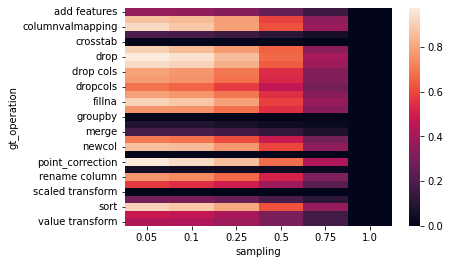

In [32]:
# Real World Performance
real_dir = '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/real-world_sample_timing'
r_edges_df, r_gt_graphs, r_relic_result_df = process_directory(real_dir)
r_pivoted_edges = pivot_and_normalize_edges_df(r_edges_df, score_col='jaccard', indexed=False, normalize_base_col=(1.0))
aggregate_and_display_heatmap(r_pivoted_edges)

In [ ]:
#Synthetic Performance
synthetic_dir = '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing/'
edges_df, gt_graphs, relic_result_df = process_directory(synthetic_dir)
pivoted_edges = pivot_and_normalize_edges_df(edges_df, score_col='jaccard', indexed=False, normalize_base_col=(1.0))
aggregate_and_display_heatmap(pivoted_edges)


In [13]:
relic_result_df

,Precision,Recall,F1,correct_edges,to_add,to_remove,nb_name,result_type,sampling,index
0,1.0,1.0000,1.000000,"{(green_taxi__8.csv, green_taxi__7.csv), (trai...",{},{},nyc-cab,relic,1.00,False
1,1.0,1.0000,1.000000,"{(green_taxi__8.csv, green_taxi__7.csv), (trai...",{},{},nyc-cab,relic,1.00,True
2,0.0,0.0000,0.000000,{},"{(train_data__2.csv, green_taxi__11.csv), (tra...",{},nyc-cab,relic,0.05,False
3,1.0,0.4375,0.608696,"{(green_taxi__8.csv, green_taxi__7.csv), (gree...","{(train_data__2.csv, green_taxi__11.csv), (tra...",{},nyc-cab,relic,0.05,True
4,0.0,0.0000,0.000000,{},"{(train_data__2.csv, green_taxi__11.csv), (tra...",{},nyc-cab,relic,0.10,False
...,...,...,...,...,...,...,...,...,...,...
58,1.0,0.8000,0.888889,"{(extract_user_repo.csv, repo_users.csv), (rep...","{(users_ren_col.csv, repo_users.csv)}",{},githubviz,relic,0.75,True
59,0.0,0.0000,0.000000,{},"{(extract_user_repo.csv, repo_users.csv), (use...",{},githubviz,relic,0.10,False
60,1.0,0.8000,0.888889,"{(extract_user_repo.csv, repo_users.csv), (rep...","{(users_ren_col.csv, repo_users.csv)}",{},githubviz,relic,0.05,True
61,1.0,0.6000,0.750000,"{(users_ren_col.csv, user-geocodes-dump.csv), ...","{(extract_user_repo.csv, repo_users.csv), (use...",{},githubviz,relic,0.25,False


sampling,0.05,0.10,0.25,0.50,0.75,1.00
gt_operation,,,,,,
assign,4.553320e-17,4.553320e-17,4.553320e-17,4.553320e-17,4.553320e-17,0.0
dropcol,6.593053e-18,6.593053e-18,6.593053e-18,6.593053e-18,6.593053e-18,0.0
groupby,2.818685e-03,1.703583e-03,2.244182e-03,1.377749e-03,7.818607e-04,0.0
merge,3.156878e-03,1.873247e-03,2.065485e-03,1.341549e-03,9.104012e-04,0.0
pivot,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
point_edit,4.208796e-03,3.605937e-03,1.326645e-03,6.929300e-04,2.146170e-05,0.0
sample,5.217236e-01,5.055640e-01,4.521508e-01,3.371638e-01,1.927328e-01,0.0


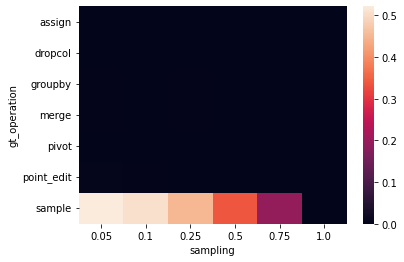

In [22]:
# Synthetic PPO Performance

pivoted_edges = pivot_and_normalize_edges_df(edges_df, score_col='jaccard', indexed=True, normalize_base_col=(1.0))
aggregate_and_display_heatmap(pivoted_edges)

In [ ]:
# TODO - per detector breakdowns
# TODO F1 Score breakdowns

In [ ]:
len(j_edges_df.index)

# F1 Score

In [68]:
relic_result_df.pivot(index='nb_name', columns=['sampling', 'index'], values='F1').dropna()

sampling             1.00                0.50      0.05                0.75  \
index               False      True     False      True     False     False   
nb_name                                                                       
20210126-153738  0.947368  0.947368  0.303030  0.555556  0.083333  0.363636   
20210126-153743  0.947368  0.947368  0.432432  0.684211  0.064516  0.648649   
20210126-153746  1.000000  1.000000  0.514286  0.684211  0.166667  0.444444   
20210126-153752  0.947368  0.947368  0.625000  0.580645  0.086957  0.625000   
20210126-153755  0.947368  0.947368  0.470588  0.540541  0.160000  0.529412   
...                   ...       ...       ...       ...       ...       ...   
20210126-180336  0.877551  0.877551  0.714286  0.734177  0.000000  0.752941   
20210126-180914  0.938776  0.938776  0.731183  0.659091  0.000000  0.774194   
20210126-181053  0.897959  0.897959  0.673684  0.564706  0.086957  0.762887   
20210126-181616  0.969072  0.969072  0.626506  0.649351  0.000000  0.658824   
20210126-181637  0.938776  0.938776  0.635294  0.615385  0.107143  0.744186   

sampling                       0.50      0.10                0.25            
index                True      True     False      True     False      True  
nb_name                                                                      
20210126-153738  0.571429  0.647059  0.083333  0.555556  0.129032  0.606061  
20210126-153743  0.918919  0.842105  0.235294  0.800000  0.486486  0.864865  
20210126-153746  0.944444  0.944444  0.173913  0.684211  0.352941  0.684211  
20210126-153752  0.685714  0.774194  0.000000  0.645161  0.451613  0.551724  
20210126-153755  0.800000  0.742857  0.307692  0.578947  0.312500  0.666667  
...                   ...       ...       ...       ...       ...       ...  
20210126-180336  0.837209  0.837209  0.000000  0.734177  0.575000  0.795181  
20210126-180914  0.875000  0.863158  0.000000  0.682353  0.682927  0.764045  
20210126-181053  0.857143  0.812500  0.027397  0.612245  0.554217  0.741573  
20210126-181616  0.790698  0.776471  0.076923  0.641026  0.389610  0.720930  
20210126-181637  0.795699  0.721649  0.111111  0.615385  0.444444  0.691358  

[91 rows x 12 columns]

(0.0, 1.0)

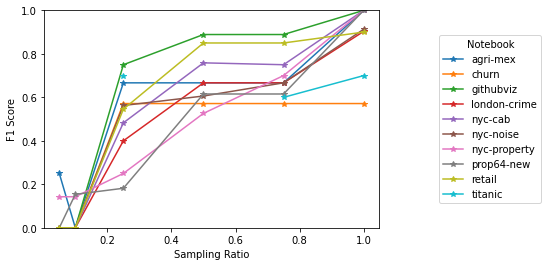

In [140]:
import matplotlib.pyplot as plt
ni_relic_df = r_relic_result_df.loc[r_relic_result_df['index'] == 'False']
ni_relic_df = ni_relic_df.pivot(index='sampling', columns=['nb_name'], values='F1')#.dropna()
ni_relic_df
#ni_plot_df = ni_relic_df.reset_index()#.merge(config_df).groupby('artifacts3').mean()
ni_relic_df.plot.line(marker="*")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), title='Notebook')
plt.xlabel('Sampling Ratio')
plt.ylabel('F1 Score')
plt.ylim(0,1)

In [70]:
ni_relic_df = relic_result_df.loc[relic_result_df['index'] == 'True']
ni_relic_df.pivot(index='nb_name', columns=['sampling'], values='F1').dropna()

sampling,0.05,0.10,0.25,0.50,0.75,1.00
nb_name,,,,,,
20210126-153738,0.555556,0.555556,0.606061,0.647059,0.571429,0.947368
20210126-153743,0.684211,0.800000,0.864865,0.842105,0.918919,0.947368
20210126-153746,0.684211,0.684211,0.684211,0.944444,0.944444,1.000000
20210126-153752,0.580645,0.645161,0.551724,0.774194,0.685714,0.947368
20210126-153755,0.540541,0.578947,0.666667,0.742857,0.800000,0.947368
...,...,...,...,...,...,...
20210126-181500,0.408163,0.408163,0.632653,0.632653,0.741573,0.979592
20210126-181532,0.571429,0.571429,0.604167,0.709677,0.733333,0.897959
20210126-181554,0.609756,0.531646,0.691358,0.714286,0.781609,1.000000


In [73]:
dataset_config_file = f'{synthetic_dir}/dataset_flat_exact_config.csv'
config_df = pd.read_csv(dataset_config_file, index_col=0).drop_duplicates()
config_df

,nb_name,artifacts3
0,20210126-153738,"20,100,10"
5,20210126-160823,"20,1000,20"
10,20210126-181616,"50,1000,20"
15,20210126-164212,"20,50000,20"
20,20210126-155943,"20,100000,10"
...,...,...
970,20210126-160531,"20,100000,10"
975,20210126-173547,"50,50000,10"
980,20210126-171247,"50,1000,10"
985,20210126-160014,"20,100000,10"


In [143]:
# Timing Calculations


def process_directory_timing(base_dir, base_score_file="cell_sim.pkl", score_type='cell', sample_score_file="ppo.csv"):
    workflow_ids = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    timing_dfs = pd.DataFrame()
    columns = ['nb_name', 'df1', 'df2', score_type, 'sampling', 'index']
    
    #print(workflow_ids)
    for i in tqdm(workflow_ids):
        #print(i)
        inferred_dir = f"{base_dir}/{i}/inferred/"
        try:
            for sample_dir in glob.glob(inferred_dir+'/sample_*_*/'):
                sample_dir_name = os.path.basename(sample_dir[:-1])
                _, index, frac = sample_dir_name.split('_')
                try:
                    timing_df = pd.read_csv(f"{sample_dir}/run_time.csv", index_col=0)
                    timing_df['index'] = index
                    timing_df['sampling'] = float(frac)
                    timing_df['nb_name'] = i
                    timing_dfs = timing_dfs.append(timing_df, ignore_index=True)
                    
                except Exception as e:
                    print(e)
                    pass
                #print(f'Not found: {sample_dir}')
        except FileNotFoundError as e:
            logging.warning(f'Could not load File: {e}')
            pass
            
    return timing_dfs


In [178]:
timing_dfs_synthetic = process_directory_timing(synthetic_dir)

  0%|          | 0/200 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181053/inferred/sample_True_0.10//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181053/inferred/sample_True_0.25//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181053/inferred/sample_False_0.75//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181053/inferred/sample_False_0.05//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181053/inferred/sample_True_0.05//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_t

[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-175111/inferred/sample_False_0.05//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-175111/inferred/sample_True_0.5//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-175111/inferred/sample_False_0.75//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-175111/inferred/sample_True_0.75//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-175111/inferred/sample_True_0.05//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_ti

[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-175603/inferred/sample_False_0.5//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-175603/inferred/sample_False_0.75//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-175603/inferred/sample_True_0.05//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-175603/inferred/sample_True_0.75//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-175603/inferred/sample_False_0.05//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_t

[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-173547/inferred/sample_True_0.75//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181345/inferred/sample_False_0.5//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181345/inferred/sample_False_0.05//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181345/inferred/sample_True_0.75//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181345/inferred/sample_True_0.05//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_ti

[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-170900/inferred/sample_True_0.5//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-174222/inferred/sample_True_0.10//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-174222/inferred/sample_False_0.10//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-174222/inferred/sample_False_0.25//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-174222/inferred/sample_True_0.25//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_ti

[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181554/inferred/sample_False_0.05//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181554/inferred/sample_False_0.75//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181554/inferred/sample_True_0.5//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181554/inferred/sample_True_0.10//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181554/inferred/sample_True_0.25//run_time.csv'
[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_ti

In [183]:
timing_dfs_synthetic_i = timing_dfs_synthetic.loc[timing_dfs_synthetic['index'] == 'True']
timing_dfs_synthetic_i

,nb_name,stage,time,index,sampling
8,20210126-161024,loading,4.829317,True,0.05
9,20210126-161024,ppo,25.521520,True,0.05
10,20210126-161024,pre_cluster,0.032512,True,0.05
11,20210126-161024,join,15.146485,True,0.05
12,20210126-161024,inter_cell,0.016847,True,0.05
...,...,...,...,...,...
10851,20210126-155237,join,20.908974,True,0.05
10852,20210126-155237,inter_cell,0.021478,True,0.05
10853,20210126-155237,inter_contain,0.016353,True,0.05
10854,20210126-155237,groupby,1.579045,True,0.05


Text(0, 0.5, 'Time (Seconds)')

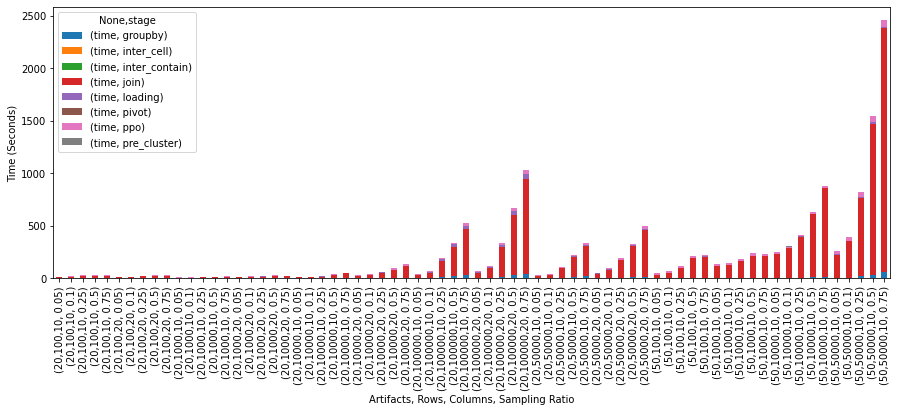

In [184]:
fig = plt.Figure(figsize=(5,5))
timing_dfs_synthetic_i = timing_dfs_synthetic_i.merge(config_df)
mean_timing = timing_dfs_synthetic_i.groupby(['artifacts3', 'sampling', 'stage']).mean().reset_index()
mean_timing.pivot(index=['artifacts3', 'sampling'], columns='stage').plot.bar(stacked=True, figsize=(15,5))
plt.xlabel('Artifacts, Rows, Columns, Sampling Ratio')
plt.ylabel('Time (Seconds)')


# Join Performance Synthetic

In [129]:
# Join Detector - Synthetic
synthetic_dir = '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing/'
j_edges_df, gt_graphs, j_relic_result_df = process_directory(synthetic_dir, 
                                                             base_score_file="triple_dict.pkl", 
                                                             score_type='join', 
                                                             sample_score_file="join.csv")
#j_edges_df['gt_operation'] = j_edges_df.apply(lambda x: is_gt_edge_join(x, gt_graphs), axis=1)
#pivoted_edges = pivot_and_normalize_edges_df(j_edges_df, score_col='join', indexed=False, normalize_base_col=(1.0))
#aggregate_and_display_heatmap(pivoted_edges)
j_edges_df

  0%|          | 0/200 [00:00<?, ?it/s]

2021-10-27 12:12:20,390 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181148/20210126-181148_gt_fixed.pkl'


,nb_name,edge,join,sampling,index
0,20210126-161024,"(1.csv, 10.csv, 16.csv)",0.000000,1.0,False
1,20210126-161024,"(10.csv, 7.csv, 18.csv)",0.000000,1.0,False
2,20210126-161024,"(17.csv, 18.csv, 8.csv)",0.129477,1.0,False
3,20210126-161024,"(10.csv, 9.csv, 18.csv)",0.000000,1.0,False
4,20210126-161024,"(1.csv, 7.csv, 16.csv)",0.000000,1.0,False
...,...,...,...,...,...
24353752,20210126-155237,"(12.csv, 6.csv, 15.csv)",0.000000,0.1,False
24353753,20210126-155237,"(1.csv, 12.csv, 8.csv)",0.000000,0.1,False
24353754,20210126-155237,"(1.csv, 8.csv, 15.csv)",0.000000,0.1,False
24353755,20210126-155237,"(1.csv, 12.csv, 15.csv)",0.000000,0.1,False


In [130]:
base_dir = synthetic_dir
def is_join_op(e_data):
    return e_data['operation'] == 'join' or e_data['operation'] == 'merge'

def add_ground_truth_join(join_scores):
    nbs = set(join_scores.nb_name)
    gt_join_edges = []
    for nb in nbs:
        try:
            gt_file = f"{base_dir}/{nb}/{nb}_gt_fixed.pkl"
            gt_graph = nx.read_gpickle(gt_file)
            nb_select = join_scores.nb_name == nb
            nb_join_triples = set()
            for u,v, uv_data in gt_graph.edges(data=True):
                if is_join_op(uv_data):
                    # Create join triple from this edge\
                    for s, t, st_data in gt_graph.in_edges(v, data=True):
                        if is_join_op(st_data) and s != u:
                            nb_join_triples.add(frozenset([u,s,v]))
            
            # Now we have the set of gt_join_edges:
            e_score_df = join_scores.loc[nb_select & (join_scores.edge.isin(nb_join_triples))].copy()
#           src_select = join_scores.src == u
#           dst_select = join_scores.dst == v
#           e_score_df = join_scores.loc[(nb_select) & (src_select) & (dst_select)].copy()
#           e_score_df['gt'] = True
            gt_join_edges.append(e_score_df)
        except FileNotFoundError as e:
            print(e)
            pass
    return pd.concat(gt_join_edges)



In [132]:
gt_joins = add_ground_truth_join(j_edges_df)


,nb_name,edge,join,sampling,index
1533610,20210126-171112,"(45.csv, 47.csv, 48.csv)",1.00000,1.00,False
1533633,20210126-171112,"(11.csv, 12.csv, 8.csv)",1.00000,1.00,False
1537566,20210126-171112,"(44.csv, 45.csv, 28.csv)",1.00000,1.00,False
1538944,20210126-171112,"(23.csv, 22.csv, 15.csv)",1.00000,1.00,False
1539732,20210126-171112,"(30.csv, 27.csv, 31.csv)",1.00000,1.00,False
...,...,...,...,...,...
10146541,20210126-153845,"(10.csv, 9.csv, 8.csv)",0.00646,0.05,True
10147407,20210126-153845,"(1.csv, 2.csv, 0.csv)",0.00000,0.05,True
10148113,20210126-153845,"(14.csv, 5.csv, 15.csv)",0.00000,0.10,False
10148547,20210126-153845,"(1.csv, 2.csv, 0.csv)",0.00000,0.10,False


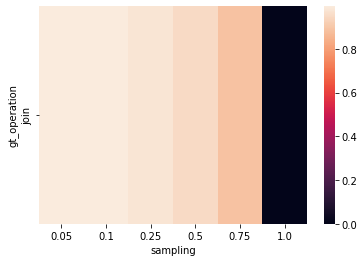

In [140]:
gt_joins['gt_operation'] = 'join'
pivoted_edges = pivot_and_normalize_edges_df(gt_joins, score_col='join', indexed=True, normalize_base_col=(1.0))
join_sampling_result = aggregate_and_display_heatmap(pivoted_edges)

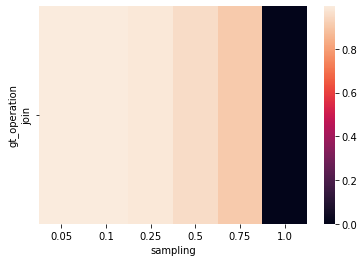

In [154]:
gt_joins['gt_operation'] = 'join'
pivoted_edges = pivot_and_normalize_edges_df(gt_joins, score_col='join', indexed=False, normalize_base_col=(1.0))
join_sampling_result = aggregate_and_display_heatmap(pivoted_edges)

In [54]:
join_scores = pd.read_csv('/mnt/roscoe/data/relic/relic_datasets_vldb_2021/analysis/dataset_flat_exact_sample_timing/joins.csv')

In [ ]:
j_edges_df.loc

In [74]:
join_scores.groupby(['nb_name','src', 'dst', 'sampling', 'index']).count()


Unnamed: 0  join  edge
nb_name         src   dst   sampling index                        
20210126-153738 0.csv 1.csv 0.05     False           3     3     3
                                     True            3     3     3
                            0.10     False           3     3     3
                                     True            3     3     3
                            0.25     False           3     3     3
...                                                ...   ...   ...
20210126-201524 9.csv 8.csv 0.25     True           34    34    34
                            0.50     False          20    20    20
                                     True           32    32    32
                            0.75     False          20    20    20
                                     True           33    33    33

[2166065 rows x 3 columns]

In [66]:
gt_join_edges = add_ground_truth_join(join_scores)
gt_join_edges

/home/suhail/.local/lib/python3.8/site-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


,0
0,Unnamed: 0 nb_name src ...
1,Unnamed: 0 nb_name src ...
2,Unnamed: 0 nb_name src ...
3,Unnamed: 0 nb_name src ...
4,Unnamed: 0 nb_name src ...
...,...
1069,Unnamed: 0 nb_name src ...
1070,Unnamed: 0 nb_name src ...
1071,Unnamed: 0 nb_name src ...
1072,Unnamed: 0 nb_name src ...


In [71]:
gt_join_edges.iloc[1000][0]

,Unnamed: 0,nb_name,src,dst,join,sampling,index,edge,gt
27056542,27056542,20210126-171602,19.csv,22.csv,1.0,1.00,False,"frozenset({'22.csv', '19.csv'})",True
27057114,27057114,20210126-171602,19.csv,22.csv,0.0,1.00,False,"frozenset({'22.csv', '19.csv'})",True
27059779,27059779,20210126-171602,19.csv,22.csv,0.0,1.00,False,"frozenset({'22.csv', '19.csv'})",True
27060696,27060696,20210126-171602,19.csv,22.csv,0.0,1.00,False,"frozenset({'22.csv', '19.csv'})",True
27064822,27064822,20210126-171602,19.csv,22.csv,0.0,1.00,False,"frozenset({'22.csv', '19.csv'})",True
27065990,27065990,20210126-171602,19.csv,22.csv,0.0,1.00,False,"frozenset({'22.csv', '19.csv'})",True
27066070,27066070,20210126-171602,19.csv,22.csv,0.0,1.00,False,"frozenset({'22.csv', '19.csv'})",True
27067380,27067380,20210126-171602,19.csv,22.csv,0.0,1.00,False,"frozenset({'22.csv', '19.csv'})",True
27068398,27068398,20210126-171602,19.csv,22.csv,0.0,1.00,False,"frozenset({'22.csv', '19.csv'})",True
27069569,27069569,20210126-171602,19.csv,22.csv,0.0,1.00,False,"frozenset({'22.csv', '19.csv'})",True


In [ ]:
pivoted_edges = pivot_and_normalize_edges_df(gt_join_edges, score_col='join', indexed=True, normalize_base_col=(1.0))
aggregate_and_display_heatmap(pivoted_edges)

# Groupby Scores Synthetic 

In [144]:
def pivot_and_normalize_gb_df(edges_df, score_col='jaccard', indexed=True, normalize_base_col=(1.0)):
    gt_edges_df = edges_df.loc[edges_df.gt_operation.notna()]
    gt_edges_df = gt_edges_df.loc[gt_edges_df['index'] == str(indexed)]
    results = gt_edges_df.pivot(index=['edge', 'nb_name', 'gt_operation'], 
                                columns=['sampling'], values=score_col).dropna()
    
    results = results.loc[results[normalize_base_col] != 0]
    
    # Normalize based on the column labelled by 'normalize_base_col', if present
    if normalize_base_col:
        for col in results.columns:
            base_col = normalize_base_col
            if col != base_col:
                #results[col] = results[base_col]  - results[col]
                results[col] =(results[base_col] - results[col]) / results[base_col]
            else:
                results[col] = 0
    return results.sort_index(axis=1)

In [38]:
# GB Detector - Synthetic
synthetic_dir = '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing/'
gb_edges_df, gt_graphs, gb_relic_result_df = process_directory(synthetic_dir, base_score_file="group_dict.pkl",
                                                               score_type='groupby', 
                                                               sample_score_file="groupby.csv")
gb_edges_df['gt_operation'] = gb_edges_df.apply(lambda x: is_gt_edge(x, gt_graphs), axis=1)

gb_edges_df.head()

,nb_name,edge,groupby,sampling,index,gt_operation
0,20210126-160736,"(1.csv, 12.csv)",0.0,1.0,False,None
1,20210126-160736,"(1.csv, 5.csv)",0.0,1.0,False,None
2,20210126-160736,"(1.csv, 11.csv)",0.0,1.0,False,None
3,20210126-160736,"(1.csv, 13.csv)",0.0,1.0,False,None
4,20210126-160736,"(1.csv, 8.csv)",0.0,1.0,False,None


In [ ]:
gb_edges_df['gt_operation'] = gb_edges_df.apply(lambda x: is_gt_edge(x, gt_graphs), axis=1)


sampling,0.05,0.10,0.25,0.50,0.75,1.00
gt_operation,,,,,,
groupby,0.993776,0.995159,0.986515,0.958506,0.919087,0.0


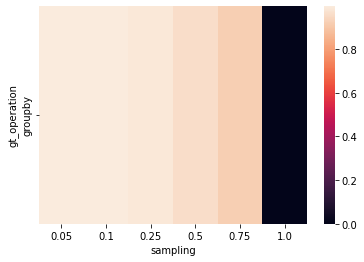

In [146]:
pivoted_edges = pivot_and_normalize_gb_df(gb_edges_df, score_col='groupby', indexed=True, normalize_base_col=(1.0))
sampling_gb_result = aggregate_and_display_heatmap(pivoted_edges)
sampling_gb_result

sampling,0.05,0.10,0.25,0.50,0.75,1.00
gt_operation,,,,,,
groupby,0.98444,0.992739,0.986515,0.976141,0.931535,0.0


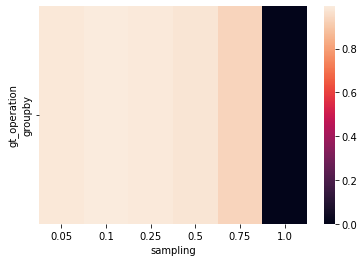

In [155]:
pivoted_edges = pivot_and_normalize_gb_df(gb_edges_df, score_col='groupby', indexed=False, normalize_base_col=(1.0))
sampling_gb_result = aggregate_and_display_heatmap(pivoted_edges)
sampling_gb_result

In [ ]:
# test_dir = '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing/20210126-153738/inferred'
# base_score_file = 'group_dict.pkl'
# gb_dict = pickle.load(open(f"{test_dir}/{base_score_file}", 'rb'))
# gb_dict
# score_dict_to_df(gb_dict)

In [36]:
gb_edges_df.loc[gb_edges_df.edge.isna()]

,nb_name,edge,groupby,sampling,index


# Pivot Edges

In [41]:
# GB Detector - Synthetic
synthetic_dir = '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing/'
p_edges_df, gt_graphs, p_relic_result_df = process_directory(synthetic_dir, base_score_file="pivot_dict.pkl",
                                                               score_type='pivot', 
                                                               sample_score_file="pivot.csv")

p_edges_df.head()

  0%|          | 0/200 [00:00<?, ?it/s]

2021-10-26 13:21:09,947 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-155003/inferred//pivot_dict.pkl'
2021-10-26 13:21:12,156 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-165259/inferred//pivot_dict.pkl'
2021-10-26 13:21:13,327 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-181053/inferred//pivot_dict.pkl'
2021-10-26 13:21:14,443 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-171230/inferred//pivot_dict.pkl'
2021-10-26 13:21:14,505 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/r

2021-10-26 13:21:54,108 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-170957/inferred//pivot_dict.pkl'
2021-10-26 13:21:54,163 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-170920/inferred//pivot_dict.pkl'
2021-10-26 13:21:54,219 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-160700/inferred//pivot_dict.pkl'
2021-10-26 13:21:55,030 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-185752/inferred//pivot_dict.pkl'
2021-10-26 13:21:56,041 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/r

2021-10-26 13:22:31,946 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-185200/inferred//pivot_dict.pkl'
2021-10-26 13:22:32,005 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-182026/inferred//pivot_dict.pkl'
2021-10-26 13:22:33,191 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-160014/inferred//pivot_dict.pkl'
2021-10-26 13:22:33,250 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing//20210126-155455/inferred//pivot_dict.pkl'
2021-10-26 13:22:37,140 root WARNING:Could not load File: [Errno 2] No such file or directory: '/mnt/roscoe/data/relic/r

,nb_name,edge,pivot,sampling,index
0,20210126-161024,"(12.csv, 16.csv)",1.000000,1.0,False
1,20210126-161024,"(16.csv, 18.csv)",0.857143,1.0,False
2,20210126-161024,"(6.csv, 16.csv)",1.000000,1.0,False
3,20210126-161024,"(1.csv, 16.csv)",1.000000,1.0,False
4,20210126-161024,"(0.csv, 16.csv)",1.000000,1.0,False


In [42]:
p_edges_df['gt_operation'] = p_edges_df.apply(lambda x: is_gt_edge(x, gt_graphs), axis=1)


sampling,0.05,0.10,0.25,0.50,0.75,1.00
gt_operation,,,,,,
pivot,0.950349,0.950467,0.918857,0.89258,0.799652,0.0


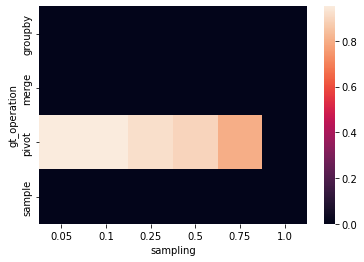

In [151]:
pivoted_edges = pivot_and_normalize_edges_df(p_edges_df, score_col='pivot', indexed=True, normalize_base_col=(1.0))
sampling_pivot_result = aggregate_and_display_heatmap(pivoted_edges)
sampling_pivot_result = sampling_pivot_result.loc[sampling_pivot_result.index == 'pivot']
sampling_pivot_result

sampling,0.05,0.10,0.25,0.50,0.75,1.00
gt_operation,,,,,,
pivot,0.950289,0.946352,0.934453,0.913472,0.810859,0.0


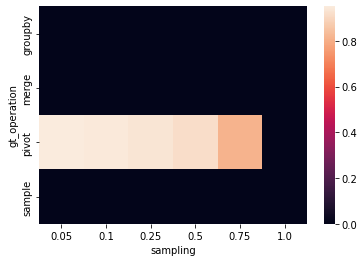

In [156]:
pivoted_edges = pivot_and_normalize_edges_df(p_edges_df, score_col='pivot', indexed=False, normalize_base_col=(1.0))
sampling_pivot_result = aggregate_and_display_heatmap(pivoted_edges)
sampling_pivot_result = sampling_pivot_result.loc[sampling_pivot_result.index == 'pivot']
sampling_pivot_result

sampling,0.05,0.10,0.25,0.50,0.75,1.00
gt_operation,,,,,,
pivot,0.950289,0.946352,0.934453,0.913472,0.810859,0.0
groupby,0.984440,0.992739,0.986515,0.976141,0.931535,0.0
join,0.994264,0.994467,0.983765,0.953944,0.905467,0.0


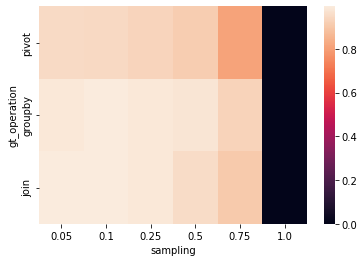

In [158]:
nppo_results = pd.concat([sampling_pivot_result, sampling_gb_result, join_sampling_result])
sns.heatmap(nppo_results)
nppo_results